In [33]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

**1. Contexto**

O Loggi Benchmark for Urban Deliveries (BUD) é um repositório do GitHub (link) com dados e códigos para problemas típicos que empresas de logística enfrentam: otimização das rotas de entrega, alocação de entregas nos veículos da frota com capacidade limitada, etc. Os dados são sintetizados de fontes públicas (IBGE, IPEA, etc.) e são representativos dos desafios que a startup enfrenta no dia a dia, especialmente com relação a sua escala.

Nós, alunos da EBAC, utilizaremos esta base de dados para gerar insights e sugerir soluções para tornar as entregas na região mais rápidas e eficientes, além de analisar a situação atual que nos foi passada e gerar visualizações gráficas deste cenário.2. Pacotes e bibliotecas

**2. Pacotes e bibliotecas**

In [2]:
# instalando o pacote não-nativo 'Geopandas':
!pip3 install geopandas;

In [3]:
# importando os pacotes que iremos utilizar neste exercício:
# import os - feito na primeira célula
import json
import matplotlib as plt
import requests
# import pandas as pd - feito na primeira célula
import seaborn as sns
# import numpy as np - feito na primeira célula
import geopandas

**3. Exploração de dados**

In [4]:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json" -O deliveries.json

with open('deliveries.json', mode='r', encoding='utf8') as file:
  data = json.load(file)

In [5]:
# limpando os dados da empresa Loggi:

deliveries_df = pd.DataFrame(data)
hub_origin_df = pd.json_normalize(deliveries_df["origin"])
deliveries_df = pd.merge(left=deliveries_df, right=hub_origin_df, how='inner', left_index=True, right_index=True)
deliveries_df = deliveries_df.drop("origin", axis=1)
deliveries_df = deliveries_df[["name", "region", "lng", "lat", "vehicle_capacity", "deliveries"]]
deliveries_df.rename(columns={"lng": "hub_lng", "lat": "hub_lat"}, inplace=True)
deliveries_exploded_df = deliveries_df[["deliveries"]].explode("deliveries")
deliveries_normalized_df = pd.concat([
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["size"])).rename(columns={"deliveries": "delivery_size"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lng"])).rename(columns={"deliveries": "delivery_lng"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lat"])).rename(columns={"deliveries": "delivery_lat"}),
], axis= 1)
deliveries_df = deliveries_df.drop("deliveries", axis=1)
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_normalized_df, how='right', left_index=True, right_index=True)
deliveries_df.reset_index(inplace=True, drop=True)

In [6]:
# checando se há algum valor NaN no DataFrame:
deliveries_df.isna().any()

name                False
region              False
hub_lng             False
hub_lat             False
vehicle_capacity    False
delivery_size       False
delivery_lng        False
delivery_lat        False
dtype: bool

In [7]:
# visualizando as primeiras 10 linhas do DataFrame:
deliveries_df.head(n=10)

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055
5,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,10,-48.120448,-15.847780
6,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.121802,-15.852089
7,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,10,-48.116300,-15.851215
8,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116317,-15.849660
9,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,8,-48.123115,-15.849925


**4. Manipulação e visualização**

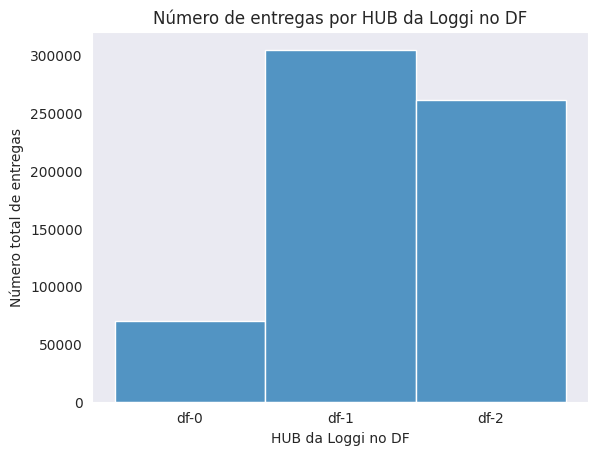

In [8]:
# obtendo o número de entregas por HUB:
correlat_df = deliveries_df[['region', 'delivery_size']]
correlat_sorted = correlat_df.sort_values(["region", "delivery_size"], ascending=True) # para os hubs ficarem em ordem crescente

with sns.axes_style('dark'):
  grafico = sns.histplot(data=correlat_sorted, x="region")
  grafico.set(title='Número de entregas por HUB da Loggi no DF', xlabel='HUB da Loggi no DF', ylabel='Número total de entregas')

**Insight 1**: O gráfico mostra claramente que o HUB mais importante da Loggi no Distrito Federal é o df-1, sendo responsável pelo maior número de entregas, movimentando quase 6x mais mercadoria do que o df-0, por exemplo. O df-2 também é bastante importante para a empresa na região.

In [9]:
# conferindo se o gráfico acima é realista:

x0 = correlat_df[correlat_df['region']=='df-0'].shape[0]
x1 = correlat_df[correlat_df['region']=='df-1'].shape[0]
x2 = correlat_df[correlat_df['region']=='df-2'].shape[0]

print(f'Volume do df-0: {x0};',f'df-1: {x1}', f'e df-2: {x2}')
print('Valores condizentes com o gráfico.')

Volume do df-0: 70122; df-1: 304708 e df-2: 261319
Valores condizentes com o gráfico.


<ipython-input-10-d5a4dd596895>:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  grafico = sns.barplot(data=volume_entregas, x="region", y="delivery_size", ci=None, palette="pastel")


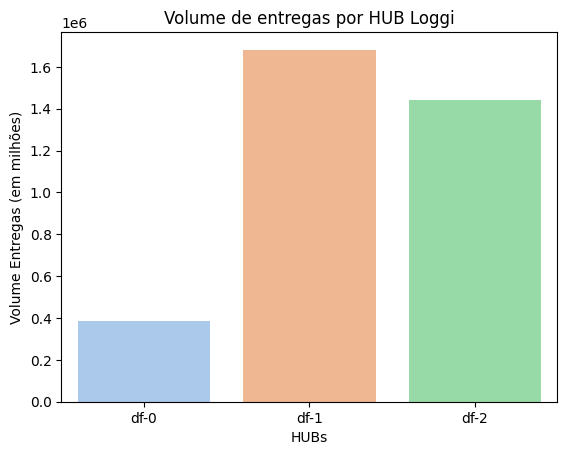

In [10]:
# obtendo o volume total de entregas de cada HUB:
volume_entregas = correlat_df[['region','delivery_size']].groupby('region').agg('sum').reset_index()

# visualizando os dados acima em um gráfico de barras:
grafico = sns.barplot(data=volume_entregas, x="region", y="delivery_size", ci=None, palette="pastel")
grafico.set(title='Volume de entregas por HUB Loggi', xlabel='HUBs', ylabel='Volume Entregas (em milhões)');

**Insight 2**: Em volume de entregas, o df-1 também é o mais importante da região, apresentando um gráfico muito parecido com o anterior. O df-0 poderia ter se mostrado mais valioso aqui, apresentando um maior volume de entregas apesar de quantidades menores de entregas (sendo um hub especial para pacotes maiores, por exemplo) mas de fato aparenta ser um hub subaproveitado.

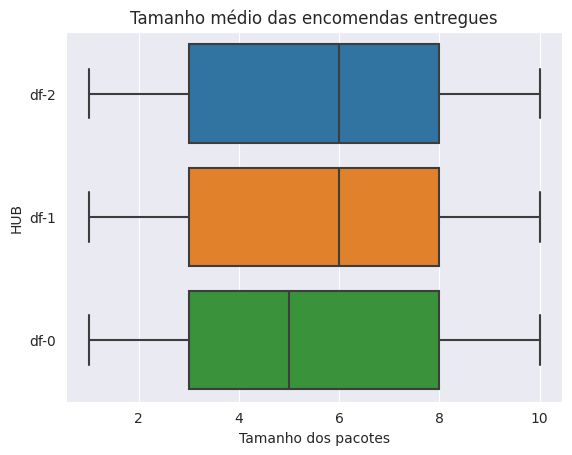

In [11]:
# visualizando o tamanho médio dos pacotes entregues:
with sns.axes_style('darkgrid'):

  grafico = sns.boxplot(x=deliveries_df["delivery_size"], y=deliveries_df["region"])
  grafico.set(title="Tamanho médio das encomendas entregues", xlabel="Tamanho dos pacotes", ylabel="HUB")

**Insight 3**: O gráfico acima mostra que o tamanho das encomendas varia de 1 a 10, com a média ficando em aproximadamente 5,5. O df-0, curiosamente, tem uma média um pouco menor do que os outros dois hubs, demonstrando que fica atrás tanto em número de entregas como no tamanho médio dos pacotes que transporta.

**5. Enriquecimento dos dados logísticos da empresa Loggi:**

In [12]:
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]]
hub_df = hub_df.drop_duplicates().sort_values(by="region").reset_index(drop=True)
hub_df.head()

,region,hub_lng,hub_lat
0,df-0,-47.802665,-15.657014
1,df-1,-47.893662,-15.805118
2,df-2,-48.054989,-15.838145


In [13]:
# importando o pacote geopy para utilizar a localização reversa, a partir da latitude e longitude disponíveis na base de dados:
import geopy
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="ebac_geocoder")
location = geolocator.reverse("-15.657013854445248, -47.802664728268745")

print(json.dumps(location.raw, indent=2, ensure_ascii=False))

{
  "place_id": 68906480,
  "licence": "Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright",
  "osm_type": "node",
  "osm_id": 6456379935,
  "lat": "-15.656819",
  "lon": "-47.8019514",
  "display_name": "Clinica dos Olhos, Rua 7, Quadra 2, Sobradinho, Região Geográfica Imediata do Distrito Federal, Região Integrada de Desenvolvimento do Distrito Federal e Entorno, Região Geográfica Intermediária do Distrito Federal, Distrito Federal, Região Centro-Oeste, 73015-202, Brasil",
  "address": {
    "amenity": "Clinica dos Olhos",
    "road": "Rua 7",
    "residential": "Quadra 2",
    "suburb": "Sobradinho",
    "town": "Sobradinho",
    "municipality": "Região Geográfica Imediata do Distrito Federal",
    "county": "Região Integrada de Desenvolvimento do Distrito Federal e Entorno",
    "state_district": "Região Geográfica Intermediária do Distrito Federal",
    "state": "Distrito Federal",
    "ISO3166-2-lvl4": "BR-DF",
    "region": "Região Centro-Oeste",
    "postcod

In [14]:
# estabelecendo um refresh rate de 1s, que é o mínimo exigido pelo geopy entre uma consulta e outra
from geopy.extra.rate_limiter import RateLimiter
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)

In [15]:
hub_df["coordinates"] = hub_df["hub_lat"].astype(str)  + ", " + hub_df["hub_lng"].astype(str)
hub_df["geodata"] = hub_df["coordinates"].apply(geocoder)
hub_df.head()

,region,hub_lng,hub_lat,coordinates,geodata
0,df-0,-47.802665,-15.657014,"-15.657013854445248, -47.802664728268745","(Clinica dos Olhos, Rua 7, Quadra 2, Sobradinh..."
1,df-1,-47.893662,-15.805118,"-15.80511751066334, -47.89366206897872","(Bloco B / F, W1 Sul, SQS 103, Asa Sul, Brasíl..."
2,df-2,-48.054989,-15.838145,"-15.83814451122274, -48.05498915846707","(Armazém do Bolo, lote 4/8, CSB 4/5, Taguating..."


In [16]:
hub_geodata_df = pd.json_normalize(hub_df["geodata"].apply(lambda data: data.raw))
hub_geodata_df.head()

,place_id,licence,osm_type,osm_id,lat,lon,display_name,boundingbox,address.amenity,address.road,...,address.ISO3166-2-lvl4,address.region,address.postcode,address.country,address.country_code,address.building,address.neighbourhood,address.city,address.shop,address.house_number
0,68906480,"Data © OpenStreetMap contributors, ODbL 1.0. h...",node,6456379935,-15.656819,-47.8019514,"Clinica dos Olhos, Rua 7, Quadra 2, Sobradinho...","[-15.656869, -15.656769, -47.8020014, -47.8019...",Clinica dos Olhos,Rua 7,...,BR-DF,Região Centro-Oeste,73015-202,Brasil,br,NaN,NaN,NaN,NaN,NaN
1,138610967,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,140908717,-15.80443735,-47.893155456691616,"Bloco B / F, W1 Sul, SQS 103, Asa Sul, Brasíli...","[-15.805071, -15.8038038, -47.8937468, -47.892...",NaN,W1 Sul,...,BR-DF,Região Centro-Oeste,70342-010,Brasil,br,Bloco B / F,SQS 103,Brasília,NaN,NaN
2,67585484,"Data © OpenStreetMap contributors, ODbL 1.0. h...",node,6249717596,-15.8384371,-48.0552917,"Armazém do Bolo, lote 4/8, CSB 4/5, Taguatinga...","[-15.8384871, -15.8383871, -48.0553417, -48.05...",NaN,CSB 4/5,...,BR-DF,Região Centro-Oeste,72015-030,Brasil,br,NaN,NaN,Taguatinga,Armazém do Bolo,lote 4/8


In [17]:
hub_geodata_df = hub_geodata_df[["address.town", "address.suburb", "address.city"]]
hub_geodata_df.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace=True)
hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])
hub_geodata_df["hub_suburb"] = np.where(hub_geodata_df["hub_suburb"].notna(), hub_geodata_df["hub_suburb"], hub_geodata_df["hub_city"])
hub_geodata_df = hub_geodata_df.drop("hub_town", axis=1)
hub_geodata_df.head()

<ipython-input-17-e7ffd1c368d3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hub_geodata_df.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace=True)
<ipython-input-17-e7ffd1c368d3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])
<ipython-input-17-e7ffd1c368d3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

,hub_suburb,hub_city
0,Sobradinho,Sobradinho
1,Asa Sul,Brasília
2,Taguatinga,Taguatinga


In [18]:
# juntando os DataFrames e gerando um novo usando .merge() :
hub_df = pd.merge(left=hub_df, right=hub_geodata_df, left_index=True, right_index=True)
hub_df = hub_df[["region", "hub_suburb", "hub_city"]]
deliveries_df = pd.merge(left=deliveries_df, right=hub_df, how="inner", on="region")
deliveries_df = deliveries_df[["name", "region", "hub_lng", "hub_lat", "hub_city", "hub_suburb", "vehicle_capacity", "delivery_size", "delivery_lng", "delivery_lat"]]
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055


Agora, faremos o download de uma base de dados para 'driblarmos' a necessidade de espera de 1 segundo entre uma consulta e outra, visto que estamos lidando com uma base de dados de mais de 600 mil registros e tornaria o processo todo extremamente lento.

In [19]:
# baixando uma base de dados para não precisar esperar o refresh de 1s:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv" -O deliveries-geodata.csv

In [20]:
# criando um novo DataFrame a partir da base de dados recém baixada:
deliveries_geodata_df = pd.read_csv("deliveries-geodata.csv")
deliveries_geodata_df.head()

,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,-48.116189,-15.848929,Ceilândia,P Sul
1,-48.118195,-15.850772,Ceilândia,P Sul
2,-48.112483,-15.847871,Ceilândia,P Sul
3,-48.118023,-15.846471,Ceilândia,P Sul
4,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


In [21]:
# juntando-o ao DF original para conter todas as informações necessárias:
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_geodata_df[["delivery_city", "delivery_suburb"]], how="inner", left_index=True, right_index=True)

In [22]:
deliveries_df.isna().any()
# Aqui vemos que o DF gerado possui alguns valores NaN's que podem prejudicar a análise dos dados posteriormente.

name                False
region              False
hub_lng             False
hub_lat             False
hub_city            False
hub_suburb          False
vehicle_capacity    False
delivery_size       False
delivery_lng        False
delivery_lat        False
delivery_city        True
delivery_suburb      True
dtype: bool

In [23]:
100 * (deliveries_df["delivery_city"].isna().sum() / len(deliveries_df))
# cálculo para sabermos quantos % das cidades na base de dados estão com valores NaN

0.26754738276724477

In [24]:
100 * (deliveries_df["delivery_suburb"].isna().sum() / len(deliveries_df))
# nos bairros, já há muito mais valores NaN, somando 25% do total.

25.133262804783158

**6. Visualização dos dados logísticos:**

In [25]:
# baixando o mapa do DF do site do IBGE:
!wget -q "https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip" -O distrito-federal.zip
!unzip -q distrito-federal.zip -d ./maps
!cp ./maps/LIM_Unidade_Federacao_A.shp ./distrito-federal.shp
!cp ./maps/LIM_Unidade_Federacao_A.shx ./distrito-federal.shx

In [26]:
# salvando esta imagem buscada na variável 'mapa':
mapa = geopandas.read_file("distrito-federal.shp")
mapa = mapa.loc[[0]]
mapa.head()

,geometry
0,"POLYGON Z ((-47.31048 -16.03602 0.00000, -47.3..."


In [28]:
# criando um novo DF a partir do original 'deliveries' e acrescentando a coluna
# 'geometry' proveniente do DF 'mapa', obtido com o geopandas:
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]].drop_duplicates().reset_index(drop=True)
geo_hub_df = geopandas.GeoDataFrame(hub_df, geometry=geopandas.points_from_xy(hub_df["hub_lng"], hub_df["hub_lat"]))
geo_hub_df.head()

# agora temos a posição geográfica de cada um dos três HUBs da Loggi no DF.

,region,hub_lng,hub_lat,geometry
0,df-2,-48.054989,-15.838145,POINT (-48.05499 -15.83814)
1,df-1,-47.893662,-15.805118,POINT (-47.89366 -15.80512)
2,df-0,-47.802665,-15.657014,POINT (-47.80266 -15.65701)


In [29]:
geo_deliveries_df = geopandas.GeoDataFrame(deliveries_df, geometry=geopandas.points_from_xy(deliveries_df["delivery_lng"], deliveries_df["delivery_lat"]))
x = len(geo_deliveries_df)
print(f'O dataframe gerado tem {x} linhas.')
geo_deliveries_df.head()

O dataframe gerado tem 636149 linhas.


,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb,geometry
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul,POINT (-48.11619 -15.84893)
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul,POINT (-48.11819 -15.85077)
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul,POINT (-48.11248 -15.84787)
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul,POINT (-48.11802 -15.84647)
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol,POINT (-48.11490 -15.85805)


<ipython-input-34-f64b9450171f>:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in lgnd.legendHandles:


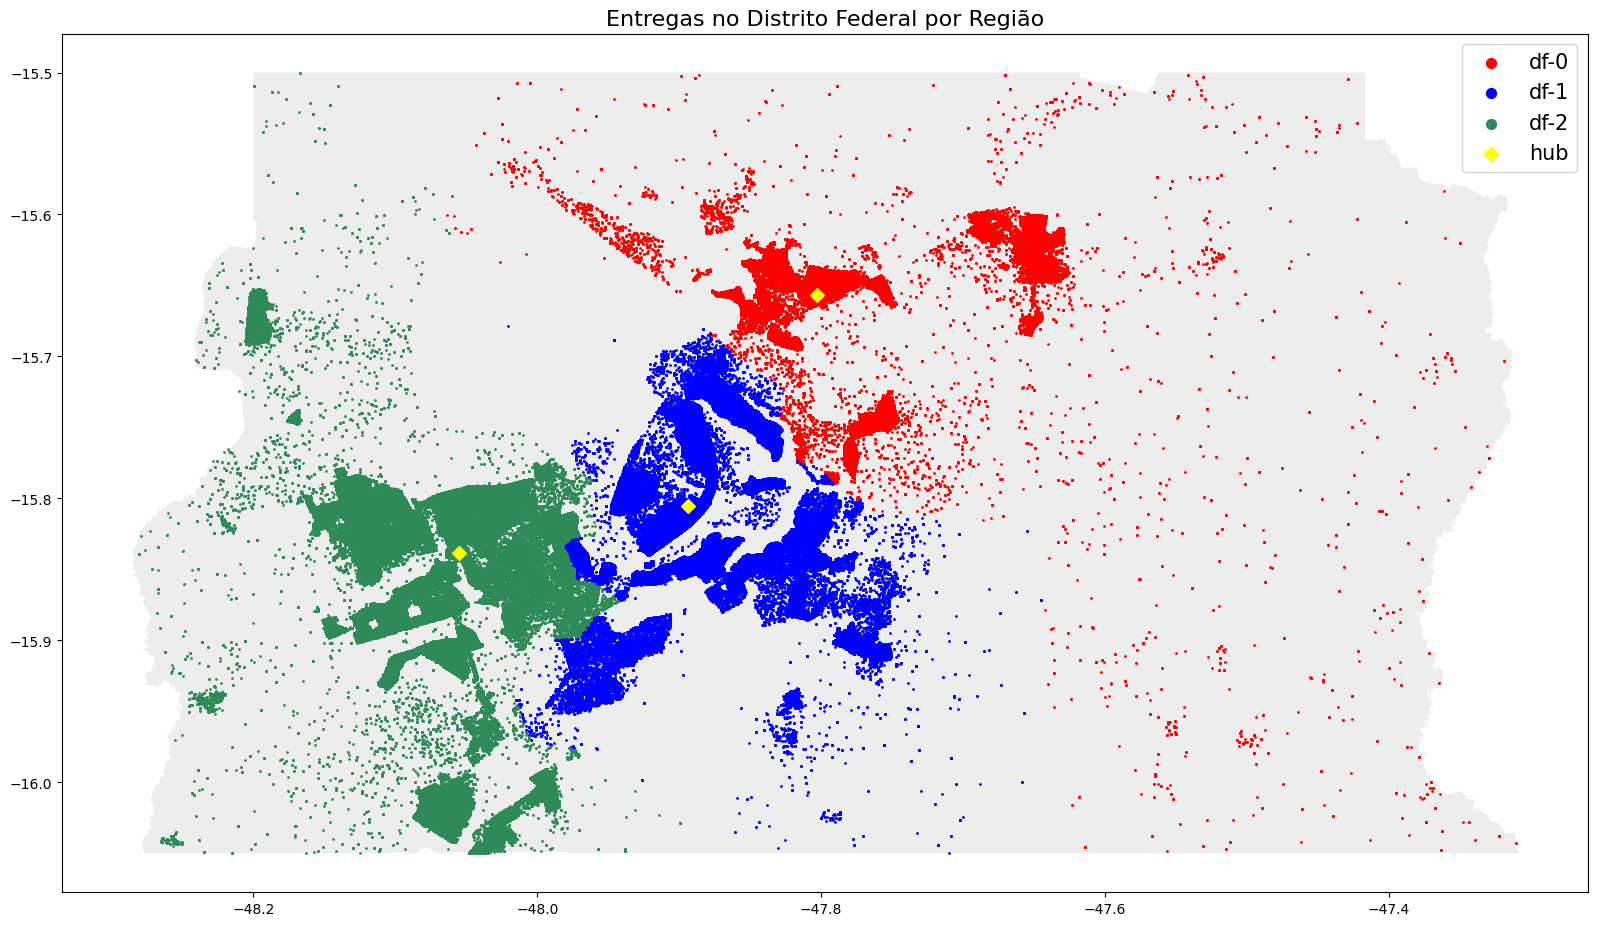

In [34]:
# cria o plot vazio
fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))

# plot mapa do distrito federal
mapa.plot(ax=ax, alpha=0.4, color="lightgrey")

# plot das entregas
geo_deliveries_df.query("region == 'df-0'").plot(ax=ax, markersize=1, color="red", label="df-0")
geo_deliveries_df.query("region == 'df-1'").plot(ax=ax, markersize=1, color="blue", label="df-1")
geo_deliveries_df.query("region == 'df-2'").plot(ax=ax, markersize=1, color="seagreen", label="df-2")

# plot dos hubs
geo_hub_df.plot(ax=ax, markersize=50, marker="D", color="yellow", label="hub")

# plot da legenda
plt.title("Entregas no Distrito Federal por Região", fontdict={"fontsize": 16})
lgnd = plt.legend(prop={"size": 15})
for handle in lgnd.legendHandles:
    handle.set_sizes([50])

**Insight 1**: Visualizando o mapa acima, entendemos melhor o número baixo de entregas do df-0 se comparado aos seus pares. A área pela qual este HUB é responsável é significativamente maior do que a área abrangida pelo df-1 e df-2. Sendo assim, a grande maioria de entregas feitas pelo HUB df-0 deve levar mais tempo, prejudicando seus números totais e sua eficiência.

**Insight 2**: Df-1 e df-2 atuam em áreas muito mais centralizadas, permitindo um maior número de entregas em um menor período de tempo, sendo HUBs muito mais eficientes do que o df-0, que cobre uma área consideravelmente maior.

**7. Possível solução para o problema apresentado pela empresa:**

A principal sugestão que surge ao visualizarmos o mapa acima seria a abertura de um novo HUB da Loggi localizado na parte leste do Distrito Federal, onde existe um grande número de pontos de entrega com distâncias consideráveis entre um e outro. Sobre a viabilidade desta ideia, há que se levar em conta que os veículos do df-0 não precisariam percorrer distâncias tão grandes em suas rotas, economizando em combustível e amenizando a depreciação dos mesmos, e ainda poderiam aliviar a carga dos outros dois HUB's da empresa na região. Talvez não seja necessária a aquisição de novos veículos e o problema possa ser resolvido (ou amenizado) com a simples distruição da frota de maneira mais equilibrada entre os 4 HUB's (já contando com o novo HUB sugerido aqui).

<ipython-input-35-2bff5d653f9b>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  grafico = sns.barplot(data=volume_entregas, x="region", y="delivery_size", ci=None, palette="pastel")


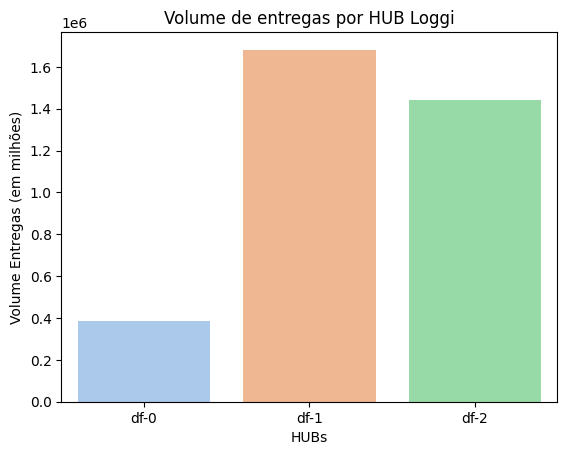

In [35]:
volume_entregas = correlat_df[['region','delivery_size']].groupby('region').agg('sum').reset_index()
grafico = sns.barplot(data=volume_entregas, x="region", y="delivery_size", ci=None, palette="pastel")
grafico.set(title='Volume de entregas por HUB Loggi', xlabel='HUBs', ylabel='Volume Entregas (em milhões)');

Trazendo novamente o gráfico que geramos acima, do volume de entregas por HUB, vemos que o df-1 é cerca de 6 vezes mais eficiente do que o df-0. Talvez seja possível, sem o aumento da frota, tornarmos mais uniforme a distribuição de entregas por cada HUB, tendo mais um ponto na parte leste do Distrito Federal. O df-0, desta forma, se tornaria muito mais eficiente e ajudaria a reduzir a carga de seus pares. Caso seja de fato necessário expandir a frota, isto pode ser comunicado pelo departamento de marketing como uma notícia extremamente positiva para os clientes da empresa em questão, já que o tempo de entrega da empresa no DF deve ser consideravelmente reduzido com a nova estrutura sugerida aqui como uma possível solução.